In [1]:
import pandas as pd
import tweepy 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import string
import re
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Twitter API credentials
BEARER_TOKEN='AAAAAAAAAAAAAAAAM4G2AEAAAAlu%2FN6xjuvhP4WkSjL4Gmk%3D8N4jkCBpLZMg07ttAvthGFFnIKfR9g4zgIOKdyre07lX'
API_KEY='3sRDHMMftbHCkynUSpzORFvce8PiMIDBXwAujwgH'
API_SECRET='FgATPEYxjTC6ZomJpGrZp'
ACCESS_TOKEN='1926669881512384-HpuquNJHvBnd50YWwmK6nNwnvB'
ACCESS_SECRET='bfeOqzgE5a7GKQBStVKdHCsFrGjj5TeYTy5P2Dx4Fv'
#Authonticate with Tweepy
auth=tweepy.OAuthHandler(API_KEY, API_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
api=tweepy.API(auth, wait_on_rate_limit=True)
#Twitter API v2 Authentication
client=tweepy.Client(bearer_token="AAAAAAAAAAAAAAAAM4G2AEAAAAAlu%2FN6xjuvhP4WkSjL4Gmk%3D8N4jkCBpLZMg07ttAvthGFFnIKfR9g4zgIOKdyre07lX")
#Define query and fetch tweetes
query="(data science OR data analysis OR machinne learning OR artificialintelligence) -is:retweet"
tweets=client.search_recent_tweets(
    query=query,
    max_results=50,
    tweet_fields=["created_at", "public_metrics", "source"],
    expansions=["author_id"],
    user_fields=["location"]
)
#Sttep 2:Map author_id to user objects
users={}
if "users" in tweets.includes:
    users={u.id:u for u in tweets.includes["users"]}
#Step 3: Extract data
tweet_list=[]
for tweet in tweets.data:
    user=user.get(tweet.author_id)
    location=user.location if user and "location" in user.data else None
    tweet_list.append([
    tweet.created_at,
    tweet.id,
    tweet.text,
    tweet.source,
    location,
    tweet.public_metrics["like_count"],
    tweet.public_metrics["retweet_count"]
])
#Step 4: Convert to DataFrame
df=pd.DataFrame(tweet-list, columns=["Date","Tweet ID","Content","Source","Location","Likes","Retweets"])
print(df.head())

#Save data to CSV
df.to_csv("mytweetsdataa.csv", index=False, encoding="utf-8")
print("Tweets saved successfully to tweets_data.csv")

In [2]:
#Load the Dataset
file_path='mytweetsdata.csv'
df=pd.read_csv(file_path)
print(df)

                         Date             Tweet ID  \
0   2025-05-27 04:30:34+00:00  1927220862354108699   
1   2025-05-27 04:30:33+00:00  1927220860923863065   
2   2025-05-27 04:30:32+00:00  1927220856159174799   
3   2025-05-27 04:30:31+00:00  1927220852501705199   
4   2025-05-27 04:30:30+00:00  1927220847602737549   
5   2025-05-27 04:30:30+00:00  1927220846570922074   
6   2025-05-27 04:30:29+00:00  1927220843899150548   
7   2025-05-27 04:30:29+00:00  1927220842817097775   
8   2025-05-27 04:30:28+00:00  1927220838111076379   
9   2025-05-27 04:30:26+00:00  1927220831458922866   
10  2025-05-27 04:30:26+00:00  1927220830322200847   
11  2025-05-27 04:30:26+00:00  1927220829395341364   
12  2025-05-27 04:30:25+00:00  1927220826463490302   
13  2025-05-27 04:30:25+00:00  1927220825804955832   
14  2025-05-27 04:30:25+00:00  1927220823770665462   
15  2025-05-27 04:30:24+00:00  1927220820310397053   
16  2025-05-27 04:30:22+00:00  1927220814358712601   
17  2025-05-27 04:30:22+00:0

In [3]:
#Display basic info
def explore_data(df):
    print("Dataset Info:")
    print(df.info())
    print("\nSample Data:")
    print(df.head())
explore_data(df)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      50 non-null     object 
 1   Tweet ID  50 non-null     int64  
 2   Content   50 non-null     object 
 3   Source    0 non-null      float64
 4   Location  30 non-null     object 
 5   Likes     50 non-null     int64  
 6   Retweets  50 non-null     int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 2.9+ KB
None

Sample Data:
                        Date             Tweet ID  \
0  2025-05-27 04:30:34+00:00  1927220862354108699   
1  2025-05-27 04:30:33+00:00  1927220860923863065   
2  2025-05-27 04:30:32+00:00  1927220856159174799   
3  2025-05-27 04:30:31+00:00  1927220852501705199   
4  2025-05-27 04:30:30+00:00  1927220847602737549   

                                             Content  Source  \
0  【図解】楽天モバイルのデータ使用量を3GBで抑える設定方法を紹介。3GB以内でストップする設...     NaN   
1  ht

In [4]:
#Clean text data
def clean_text(Content):
    text=Content.lower()
    text=re.sub(r'http\S+', '', Content)
    text=re.sub(r'@\w+', '', Content)
    text=re.sub(r'#', '', Content)
    text=re.sub(r'[a-zA-Z]', '', Content)
    words= word_tokenize(Content)
    words=[word for word in words if word not in stopwords.words('english')]
    return ' '.join(words)
#Apply text cleaning
df['cleaned_text']=df['Content'].astype(str).apply(clean_text)

In [5]:
#Perform sentiment analysis
def get_sentiment(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'
df['Sentiment']=df['cleaned_text'].apply(get_sentiment)

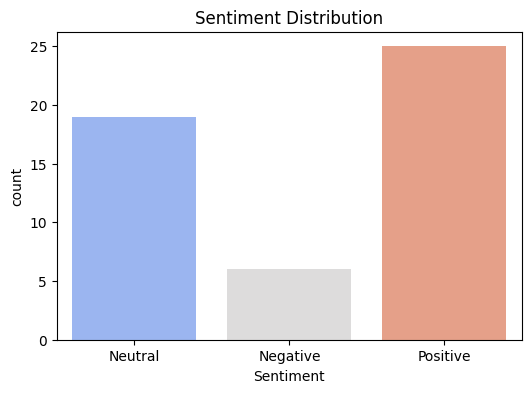

In [6]:
#Sentiment distributin
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Sentiment', palette='coolwarm', hue='Sentiment')
plt.title("Sentiment Distribution")
plt.show()

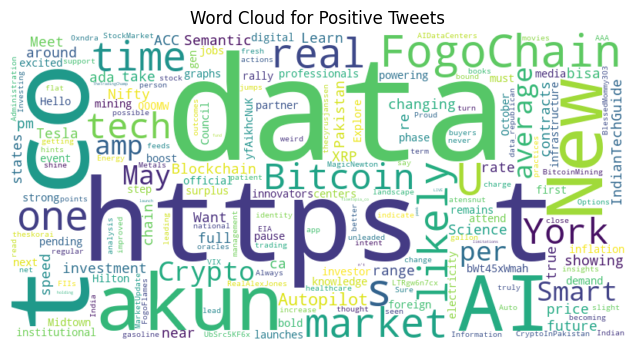

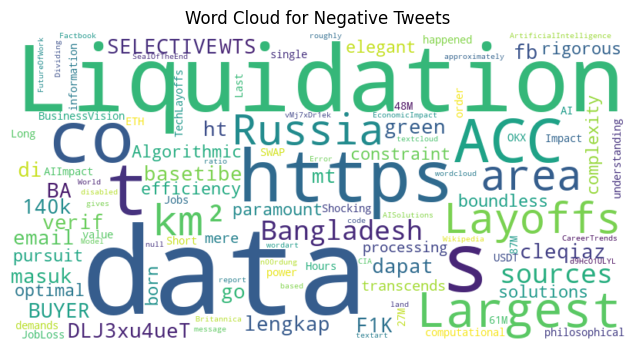

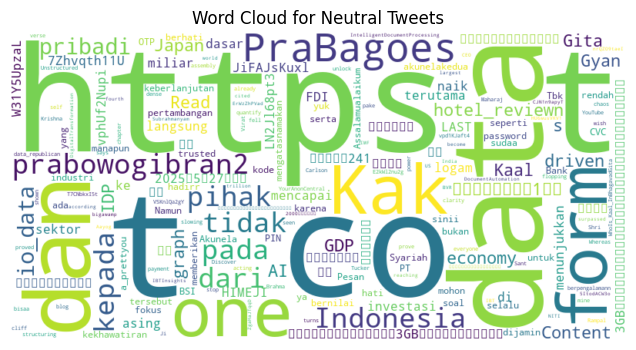

In [7]:
#Wordcloud for each sentiment
def generate_wordcloud(sentiment):
    text=' '.join(df[df['Sentiment'] == sentiment]['cleaned_text'])
    wordcloud= WordCloud(width=800, height=400,background_color='white').generate(text)
    plt.figure(figsize=(8,4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment} Tweets')
    plt.show()
generate_wordcloud('Positive')
generate_wordcloud('Negative')
generate_wordcloud('Neutral')

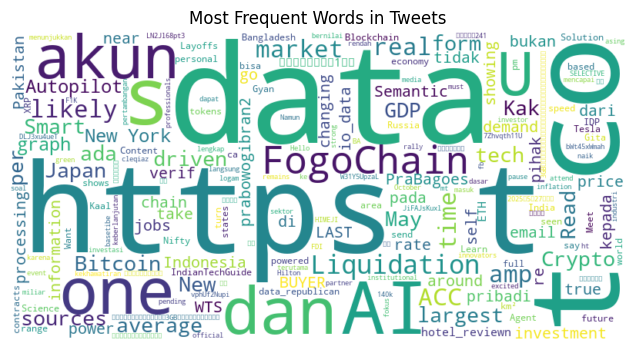

In [8]:
#
text=' '.join(df['cleaned_text'])
wordcloud= WordCloud(width=800, height=400,background_color='white').generate(text)
plt.figure(figsize=(8,4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Tweets')
plt.show()

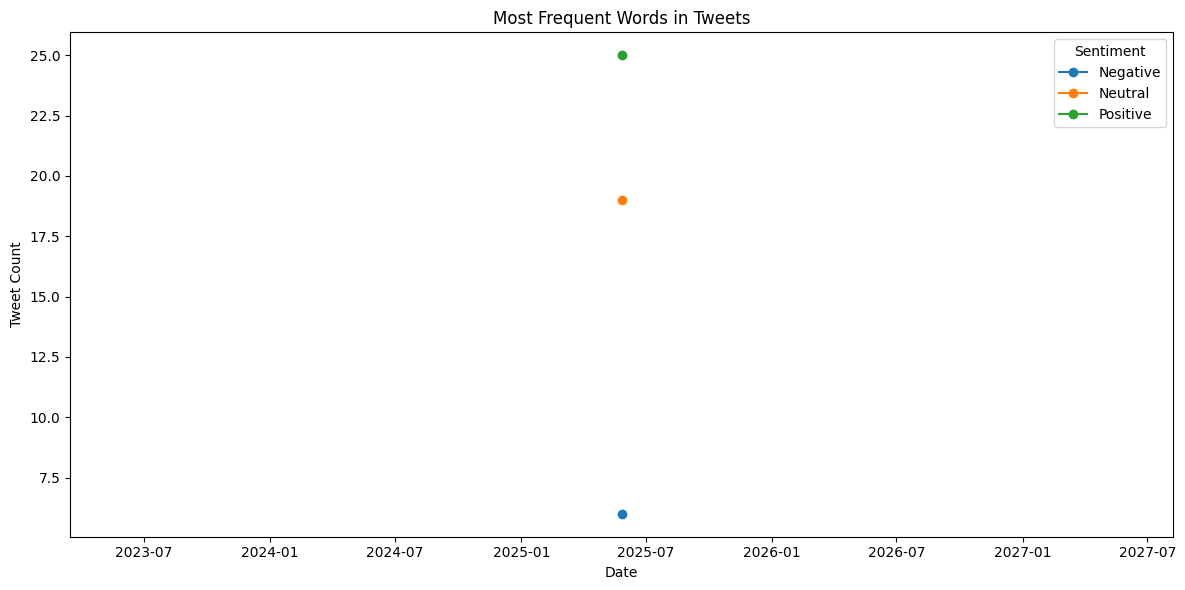

In [9]:
#Time - Series Analysis:Sentiment trends over time using 'date' column
if 'Date' in df.columns and 'Sentiment' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    sentiment_trend=df.groupby([df['Date'].dt.date,'Sentiment']).size().unstack().fillna(0)
    sentiment_trend.plot(kind='line', figsize=(12,6), marker='o')
    plt.title('Most Frequent Words in Tweets')
    plt.xlabel('Date')
    plt.ylabel('Tweet Count')
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.show()
else:
    print("Required columns not fouund in dataset.")
    

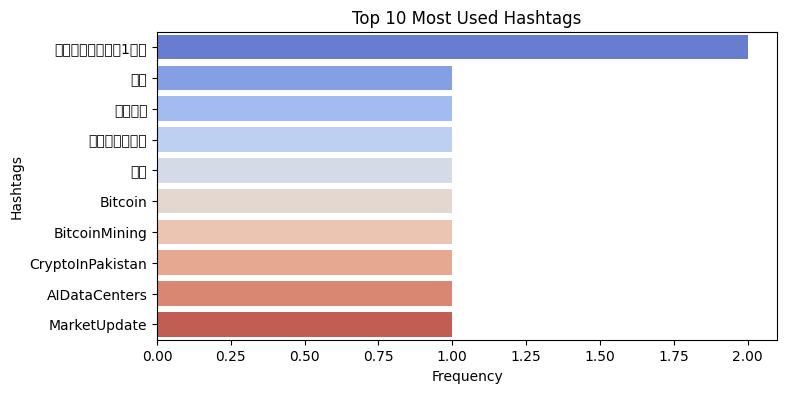

In [10]:
def extract_hashtags(Content):
    return re.findall(r'#(\w+)', Content)
df['hashtags']= df['Content'].apply(extract_hashtags)
all_hashtags=sum(df['hashtags'], [])
hashtags_freq=pd.Series(all_hashtags).value_counts().head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=hashtags_freq.values, y=hashtags_freq.index, hue=hashtags_freq.index, palette='coolwarm', legend=False)
plt.title('Top 10 Most Used Hashtags')
plt.xlabel('Frequency')
plt.ylabel('Hashtags')
plt.show()

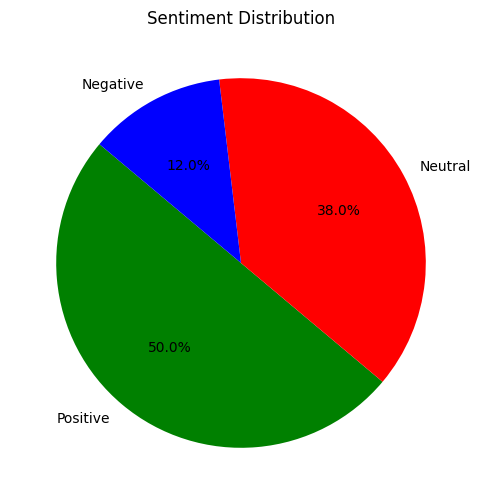

In [11]:
#Pie Chart 
plt.figure(figsize=(6,6))
df['Sentiment'].value_counts().plot.pie(autopct='%1.1f%%',colors=['green','red','blue'],startangle=140)
plt.title('Sentiment Distribution')
plt.ylabel('')
plt.show()

In [12]:
from  sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

In [13]:
# Convert sentiment labels to numrics
df=df[df['Sentiment'] != 'Neutral']
df['label'] = df['Sentiment'].map({'Positive':1, 'Negative':0})
#text Vectorizer
tfidf = TfidfVectorizer(max_features=3000)
X= tfidf.fit_transform(df['cleaned_text'])
y= df['label']
# Train-Test-Split
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [14]:
#Define models
models = {
    "K-Nearest Neighbor": KNeighborsClassifier(),
    "Support Vector Machine": LinearSVC(),
    "NAive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

In [15]:
# train, Predict, and Evaluate
fitted_models ={}
for name, model in models.items():
    print(f"\n{name} Result:")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuarcy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
    fitted_models[name] = model


K-Nearest Neighbor Result:
Accuarcy: 0.7142857142857143
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         2
    Positive       0.71      1.00      0.83         5

    accuracy                           0.71         7
   macro avg       0.36      0.50      0.42         7
weighted avg       0.51      0.71      0.60         7


Support Vector Machine Result:
Accuarcy: 0.7142857142857143
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         2
    Positive       0.71      1.00      0.83         5

    accuracy                           0.71         7
   macro avg       0.36      0.50      0.42         7
weighted avg       0.51      0.71      0.60         7


NAive Bayes Result:
Accuarcy: 0.7142857142857143
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         2
    Positive       0.71      1.00      0.83         5

    accuracy  

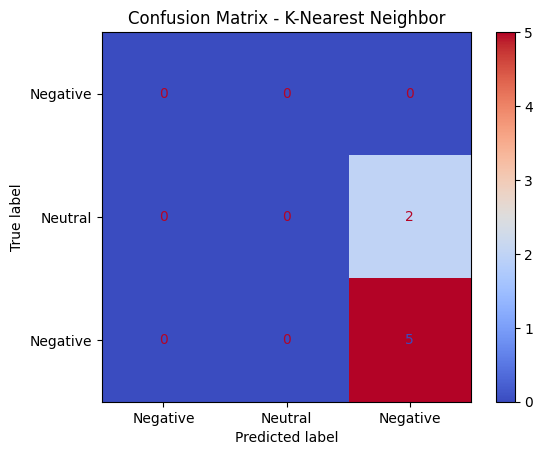

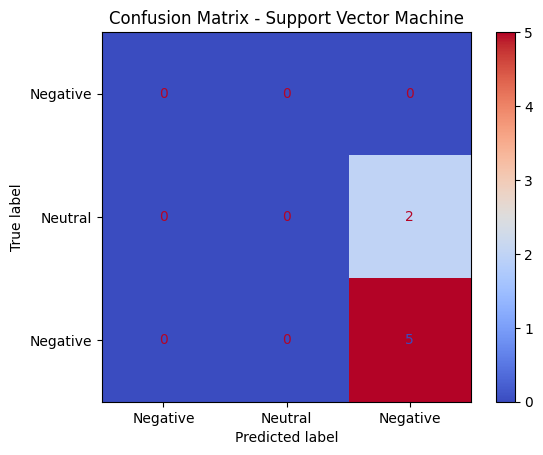

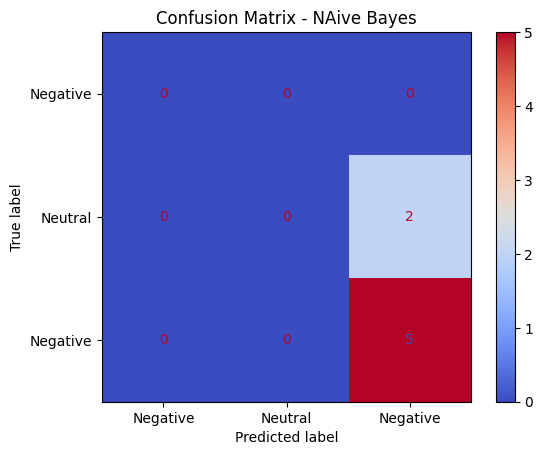

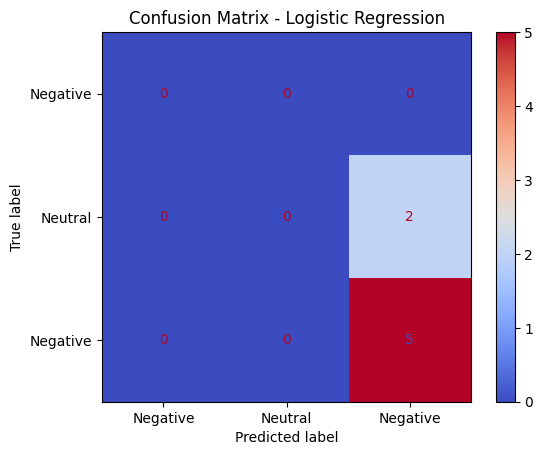

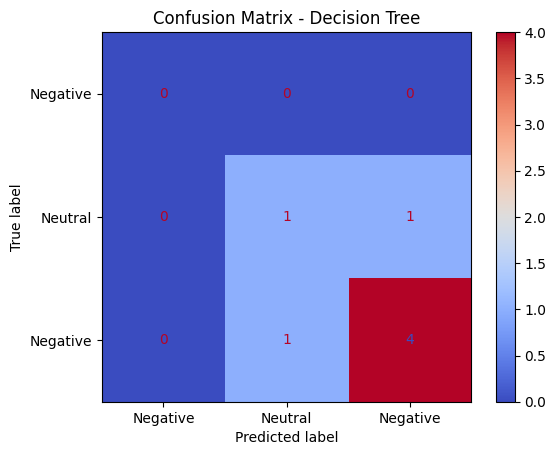

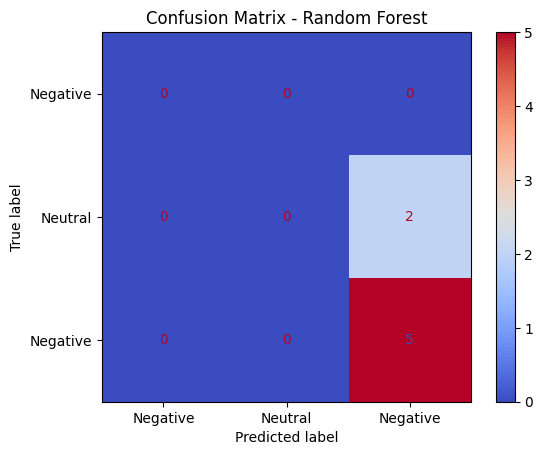

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Loop through models and display confusion matrix
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=[-1,0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Negative"])
    disp.plot(cmap='coolwarm')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

In [17]:
def show_top_words(model, vectorizer, n=10):
    feature_names = vectorizer.get_feature_names_out()
    coefs = model.coef_[0]
    top_positive = sorted(zip(coefs, feature_names))[-n:]
    top_negative = sorted(zip(coefs, feature_names))[:n]
    print("Top Positive Words:")
    for coef, word in reversed(top_positive):
        print(f"{word}: {coef:.4f}")
        print("\nTop Negative Words:")
    for coef, word in top_negative:
        print(f"{word}: {coef:.4f}")
show_top_words(models["Logistic Regression"], tfidf)          

Top Positive Words:
fogochain: 0.1662

Top Negative Words:
akun: 0.1084

Top Negative Words:
time: 0.0932

Top Negative Words:
like: 0.0919

Top Negative Words:
real: 0.0877

Top Negative Words:
one: 0.0865

Top Negative Words:
new: 0.0864

Top Negative Words:
2025: 0.0862

Top Negative Words:
ai: 0.0782

Top Negative Words:
likely: 0.0743

Top Negative Words:
liquidation: -0.4359
acc: -0.2368
largest: -0.2179
the: -0.1997
30003: -0.1958
403: -0.1958
code: -0.1958
disabled: -0.1958
error: -0.1958
message: -0.1958


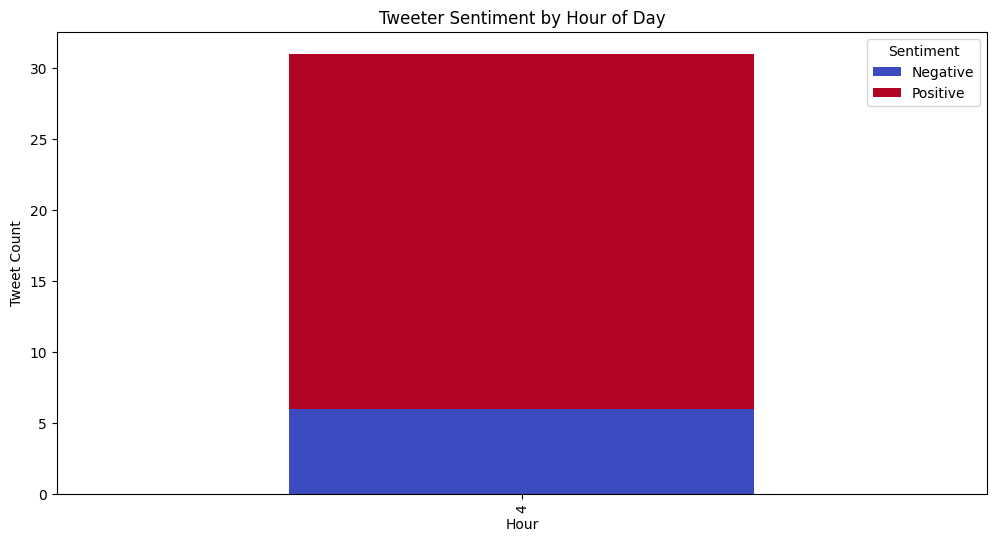

In [18]:
#Check and process
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce') #Convert to datetime safely
    df['hour'] = df['Date'].dt.hour #Extract hour
    if 'Sentiment' in df.columns:
        hourly_sentiment = df.groupby(['hour', 'Sentiment']).size().unstack().fillna(0)
        hourly_sentiment.plot(kind='bar', stacked=True, figsize=(12,6), colormap='coolwarm')
        plt.title("Tweeter Sentiment by Hour of Day")
        plt.xlabel("Hour")
        plt.ylabel("Tweet Count")
        plt.show()
    else:
        print("Sentiment column not found.")
else:
    print("Date column not found.")
                                                                            

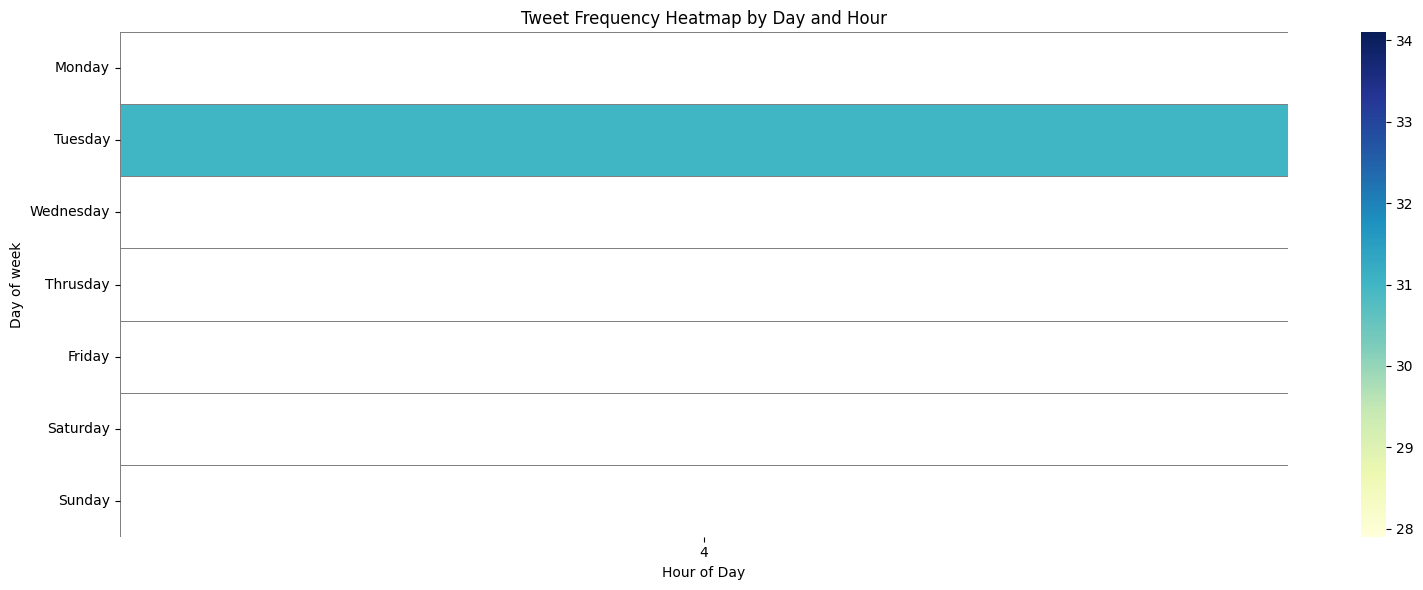

In [19]:
#plot the heatmap
#Heaatmap:Tweet frequency by day and hour
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
#Extract day of the week and hour of the day
df['Day'] = df['Date'].dt.day_name()
df['Hour'] = df['Date'].dt.hour
#Create a pivot table: count of tweets by Day and Hour
heatmap_data=df.pivot_table(index='Day', columns='Hour', values='Content', aggfunc='count').fillna(0)
#Reoder the day for a logical view
ordered_days=['Monday', 'Tuesday', 'Wednesday', 'Thrusday', 'Friday', 'Saturday', 'Sunday']
heatmap_data= heatmap_data.reindex(ordered_days)
plt.figure(figsize=(16,6))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=.5, linecolor='gray')
plt.title('Tweet Frequency Heatmap by Day and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of week')
plt.tight_layout()
plt.show()

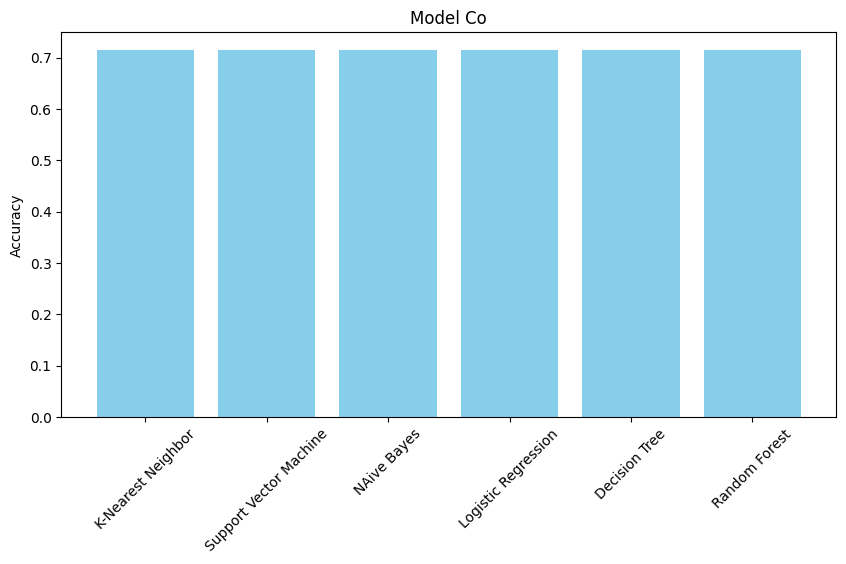

In [20]:
import matplotlib.pyplot as plt
accuracy_scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy_scores[name] = accuracy_score(y_test, y_pred)

#Bar plot
plt.figure(figsize=(10,5))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color='skyblue')
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.title("Model Co")
plt.show()

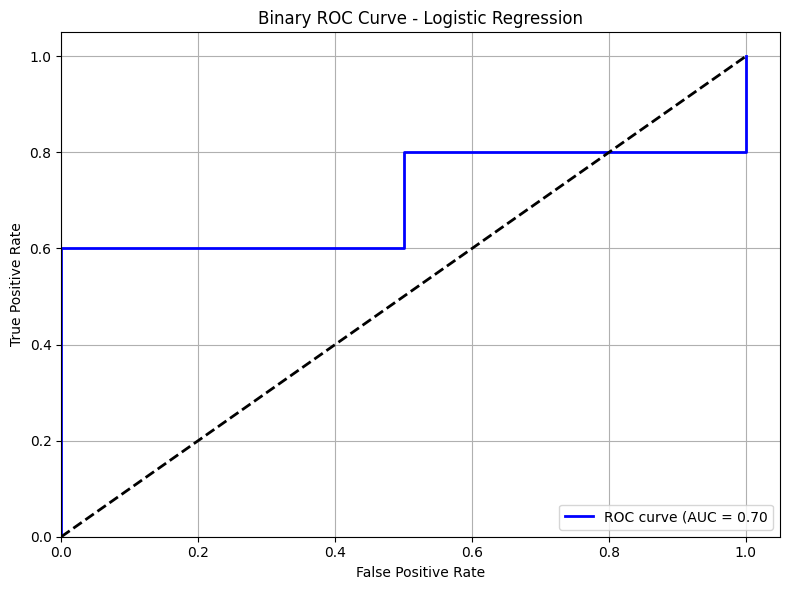

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
chosen_model = fitted_models['Logistic Regression']
y_score = chosen_model.decision_function(X_test)

#Computte ROC and AUC
fpr, tpr, _= roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

#plot ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1], 'k--',lw=2)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()